In [1]:
## import statements ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score


## Data preprocessing

In [2]:
## load data ##

data_rain = pd.read_csv('data_mrc/Rainfall_StungTreng.csv')
data_flow = pd.read_csv('data_mrc/Discharge_StungTreng.csv')

data_rain = data_rain.rename(columns={'Value': 'rainfall'})
data_flow = data_flow.rename(columns={'Value': 'flowrate'})

data_rain = data_rain[['Timestamp (UTC+07:00)', 'rainfall']]
data_flow = data_flow[['Timestamp (UTC+07:00)', 'flowrate']]

# merge data
df = pd.merge(data_rain, data_flow, on='Timestamp (UTC+07:00)', how='inner')
df['Timestamp (UTC+07:00)'] = pd.to_datetime(df['Timestamp (UTC+07:00)'], format='%Y-%m-%d %H:%M:%S')
df = df.rename(columns={'Timestamp (UTC+07:00)': 'date'})
df.set_index('date', inplace=True)

# Calculate the minimum flowrate over the past week / month (base flowrate)
df['min_flow_week'] = df['flowrate'].rolling(window=7, min_periods=1).min()
df['min_flow_month'] = df['flowrate'].rolling(window=30, min_periods=1).min()

scaler = StandardScaler()
df[['rainfall', 'flowrate', 'min_flow_week', 'min_flow_month']] = scaler.fit_transform(df[['rainfall', 'flowrate', 'min_flow_week', 'min_flow_month']])

In [3]:
## encode datetime ##

# extract DateTime components
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear
df['week_of_year'] = df.index.isocalendar().week.astype(int)

# encode cyclical features
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

In [4]:
df.describe()

,rainfall,flowrate,min_flow_week,min_flow_month,year,month,day,day_of_week,day_of_year,week_of_year,day_of_week_sin,day_of_week_cos
count,4.693000e+03,4.693000e+03,4.693000e+03,4.693000e+03,4693.000000,4693.000000,4693.000000,4693.000000,4693.000000,4693.000000,4693.000000,4693.000000
mean,5.147763e-17,-9.992717e-17,9.689907e-17,-1.090115e-16,2015.530151,6.604304,15.646708,3.004688,185.512465,26.871724,-0.002319,0.000127
std,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,4.122149,3.346634,8.812848,2.001699,102.276153,14.598409,0.707479,0.706882
min,-4.130685e-01,-1.006312e+00,-1.003426e+00,-9.790854e-01,2007.000000,1.000000,1.000000,0.000000,1.000000,1.000000,-0.974928,-0.900969
25%,-4.130685e-01,-7.344459e-01,-7.253982e-01,-6.652498e-01,2012.000000,4.000000,8.000000,1.000000,99.000000,14.000000,-0.781831,-0.900969
50%,-4.130685e-01,-5.080155e-01,-4.936505e-01,-4.632525e-01,2015.000000,7.000000,16.000000,3.000000,189.000000,27.000000,0.000000,-0.222521
75%,-1.103875e-01,5.516795e-01,4.977898e-01,4.047674e-01,2019.000000,9.000000,23.000000,5.000000,272.000000,39.000000,0.781831,0.623490
max,9.703202e+00,3.897269e+00,4.036488e+00,4.263678e+00,2024.000000,12.000000,31.000000,6.000000,366.000000,53.000000,0.974928,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4693 entries, 2007-03-07 00:00:00+00:00 to 2024-05-06 00:00:00+00:00
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rainfall         4693 non-null   float64
 1   flowrate         4693 non-null   float64
 2   min_flow_week    4693 non-null   float64
 3   min_flow_month   4693 non-null   float64
 4   year             4693 non-null   int64  
 5   month            4693 non-null   int64  
 6   day              4693 non-null   int64  
 7   day_of_week      4693 non-null   int64  
 8   day_of_year      4693 non-null   int64  
 9   week_of_year     4693 non-null   int32  
 10  day_of_week_sin  4693 non-null   float64
 11  day_of_week_cos  4693 non-null   float64
dtypes: float64(6), int32(1), int64(5)
memory usage: 458.3 KB


In [6]:
df.columns

Index(['rainfall', 'flowrate', 'min_flow_week', 'min_flow_month', 'year',
       'month', 'day', 'day_of_week', 'day_of_year', 'week_of_year',
       'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

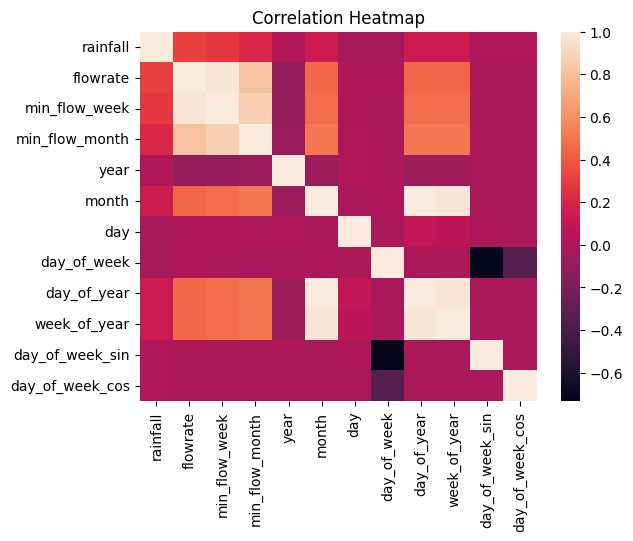

In [7]:
sns.heatmap(df.corr())
plt.title('Correlation Heatmap')
plt.show()

In [8]:
## split data (no baseflow included) ##

X = df[['rainfall', 'week_of_year']] # ajouter rainfall de la veille et moyenne de la semaine précédente
y = df['flowrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# order data
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()

In [9]:
## split data (baseflow included) ##

X_week = df[['rainfall', 'year', 'month', 'day', 'day_of_week', 'day_of_year', 'week_of_year', 'day_of_week_sin', 'day_of_week_cos', 'min_flow_week']]
y_week = df['flowrate']

X_train_week, X_test_week, y_train_week, y_test_week = train_test_split(X_week, y_week, test_size=0.2, random_state=42)

X_train_week = X_train_week.sort_index()
y_train_week = y_train_week.sort_index()
X_test_week = X_test_week.sort_index()
y_test_week = y_test_week.sort_index()

X_month = df[['rainfall', 'year', 'month', 'day', 'day_of_week', 'day_of_year', 'week_of_year', 'day_of_week_sin', 'day_of_week_cos', 'min_flow_month']]
y_month = df['flowrate']

X_train_month, X_test_month, y_train_month, y_test_month = train_test_split(X_month, y_month, test_size=0.2, random_state=42)

X_train_month = X_train_month.sort_index()
y_train_month = y_train_month.sort_index()
X_test_month = X_test_month.sort_index()
y_test_month = y_test_month.sort_index()

## Models

In [10]:
## Linear Regression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# evaluate model
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print("Linear Regression Model")
print("Mean Squared Error:", lr_mse)
print("R-squared:", lr_r2)

Linear Regression Model
Mean Squared Error: 0.7842758230680156
R-squared: 0.27344867339829404


In [11]:
## Linear Regression (with weekly baseflow)

lr_model_week = LinearRegression()
lr_model_week.fit(X_train_week, y_train_week)
lr_pred_week = lr_model_week.predict(X_test_week)

# evaluate model
lr_mse_week = mean_squared_error(y_test_week, lr_pred_week)
lr_r2_week = r2_score(y_test_week, lr_pred_week)

print("Linear Regression Model (with weekly baseflow)")
print("Mean Squared Error:", lr_mse_week)
print("R-squared:", lr_r2_week)

## Linear Regression (with monthly baseflow)

lr_model_month = LinearRegression()
lr_model_month.fit(X_train_month, y_train_month)
lr_pred_month = lr_model_month.predict(X_test_month)

# evaluate model
lr_mse_month = mean_squared_error(y_test_month, lr_pred_month)
lr_r2_month = r2_score(y_test_month, lr_pred_month)

print("\nLinear Regression Model (with monthly baseflow)")
print("Mean Squared Error:", lr_mse_month)
print("R-squared:", lr_r2_month)


Linear Regression Model (with weekly baseflow)
Mean Squared Error: 0.06276603515918723
R-squared: 0.9418536887544958

Linear Regression Model (with monthly baseflow)
Mean Squared Error: 0.3561486757045495
R-squared: 0.6700646823609396


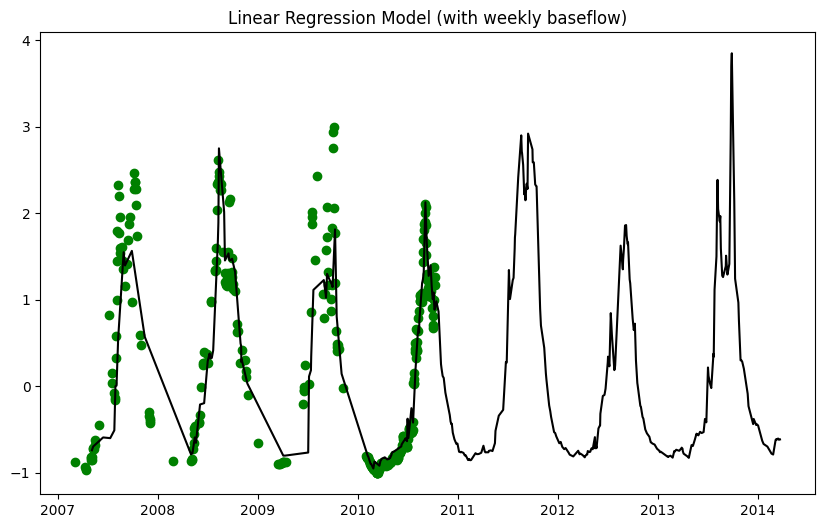

In [29]:
## plot with weekly baseflow ##
plt.figure(figsize=(10, 6))
plt.scatter(X_train.index[:365], y_train[:365],color='g')
plt.plot(X_test.index[:365], lr_pred_week[:365],color='k')
plt.title('Linear Regression Model (with weekly baseflow)')
plt.show()

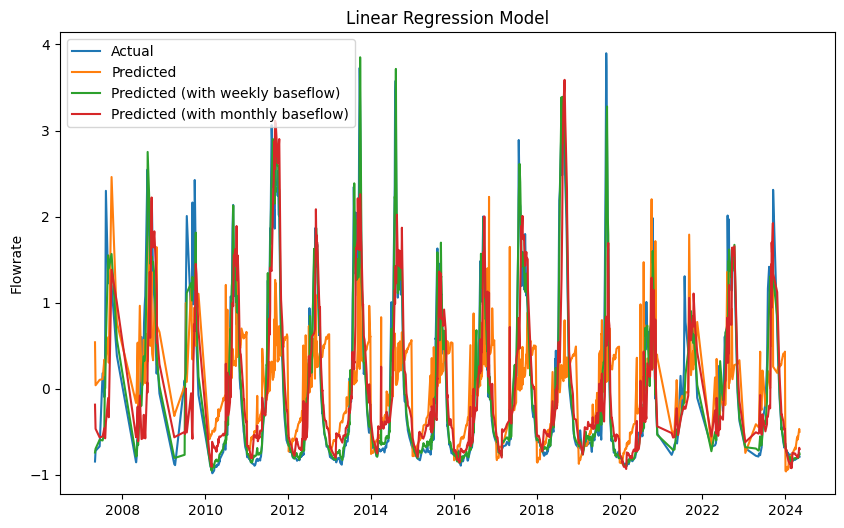

In [12]:
## plot results ##
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index,lr_pred, label='Predicted')
plt.plot(y_test.index,lr_pred_week, label='Predicted (with weekly baseflow)')
plt.plot(y_test.index,lr_pred_month, label='Predicted (with monthly baseflow)')
plt.title('Linear Regression Model')
plt.ylabel('Flowrate')
plt.legend()
plt.show()

In [21]:
## Decision Tree Regression
X_dt = df[['rainfall', 'week_of_year', 'min_flow_week']]
y_dt = df['flowrate']

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.2, random_state=42)

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_dt, y_train_dt)
dt_pred = dt_model.predict(X_test_dt)

# Evaluate model
dt_mse = mean_squared_error(y_test_dt, dt_pred)
dt_r2 = r2_score(y_test_dt, dt_pred)

print("Decision Tree Regression Model")
print("Mean Squared Error:", dt_mse)
print("R-squared:", dt_r2)

# Feature importances
dt_feature_importances = dt_model.feature_importances_
dt_features = X_dt.columns

importances_df = pd.DataFrame({'Feature': dt_features, 'Importance': dt_feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
importances_df

Decision Tree Regression Model
Mean Squared Error: 0.0789939250513211
R-squared: 0.926820208718157

Feature Importances:


,Feature,Importance
2,min_flow_week,0.962946
1,week_of_year,0.020644
0,rainfall,0.016410


In [ ]:
tree_depth = dt_model.get_depth()
num_leaves = dt_model.get_n_leaves()

print("Tree Depth:", tree_depth)
print("Number of Leaves:", num_leaves)

Tree Depth: 25
Number of Leaves: 3501


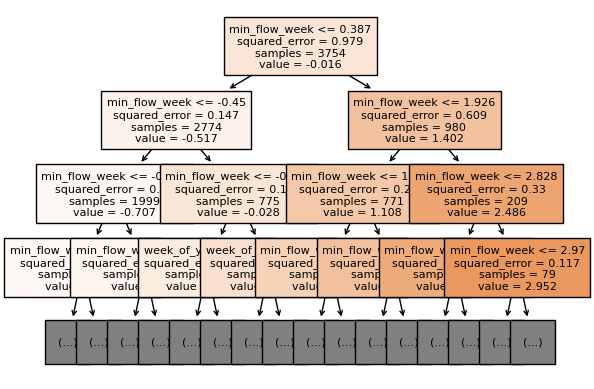

In [ ]:
features = list(X.columns)
plot_tree(dt_model, filled=True, feature_names= features, max_depth=3, fontsize=8)
plt.show()

In [ ]:
## Decision Tree Regression (with weekly baseflow) ##
dt_model_week = DecisionTreeRegressor(random_state=42)
dt_model_week.fit(X_train_week, y_train_week)
dt_pred_week = dt_model_week.predict(X_test_week)

# Evaluate model
dt_mse_week = mean_squared_error(y_test_week, dt_pred_week)
dt_r2_week = r2_score(y_test_week, dt_pred_week)

print("Decision Tree Regression Model (with weekly baseflow)")
print("Mean Squared Error:", dt_mse_week)
print("R-squared:", dt_r2_week)

dt_week_feature_importances = dt_model_week.feature_importances_
dt_week_features = X_week.columns

dt_week_importances_df = pd.DataFrame({'Feature': dt_week_features, 'Importance': dt_week_feature_importances})
dt_week_importances_df = dt_week_importances_df.sort_values(by='Importance', ascending=False)

## Decision Tree Regression (with monthly baseflow) ##
dt_model_month = DecisionTreeRegressor(random_state=42)
dt_model_month.fit(X_train_month, y_train_month)
dt_pred_month = dt_model_month.predict(X_test_month)

# Evaluate model
dt_mse_month = mean_squared_error(y_test_month, dt_pred_month)
dt_r2_month = r2_score(y_test_month, dt_pred_month)

print("\nDecision Tree Regression Model (with monthly baseflow)")
print("Mean Squared Error:", dt_mse_month)
print("R-squared:", dt_r2_month)

dt_month_feature_importances = dt_model_month.feature_importances_
dt_month_features = X_month.columns

dt_month_importances_df = pd.DataFrame({'Feature': dt_month_features, 'Importance': dt_month_feature_importances})
dt_month_importances_df = dt_month_importances_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances (week base):")
#dt_week_importances_df
print("\nFeature Importances (month base):")
dt_month_importances_df

Decision Tree Regression Model (with weekly baseflow)
Mean Squared Error: 0.06186545046008639
R-squared: 0.9426879883575223

Decision Tree Regression Model (with monthly baseflow)
Mean Squared Error: 0.06511634534476121
R-squared: 0.9396763667804814

Feature Importances (week base):

Feature Importances (month base):


,Feature,Importance
9,min_flow_month,0.666611
5,day_of_year,0.113533
6,week_of_year,0.113420
1,year,0.044445
2,month,0.038633
3,day,0.014669
0,rainfall,0.004823
7,day_of_week_sin,0.001564
8,day_of_week_cos,0.001283
4,day_of_week,0.001019


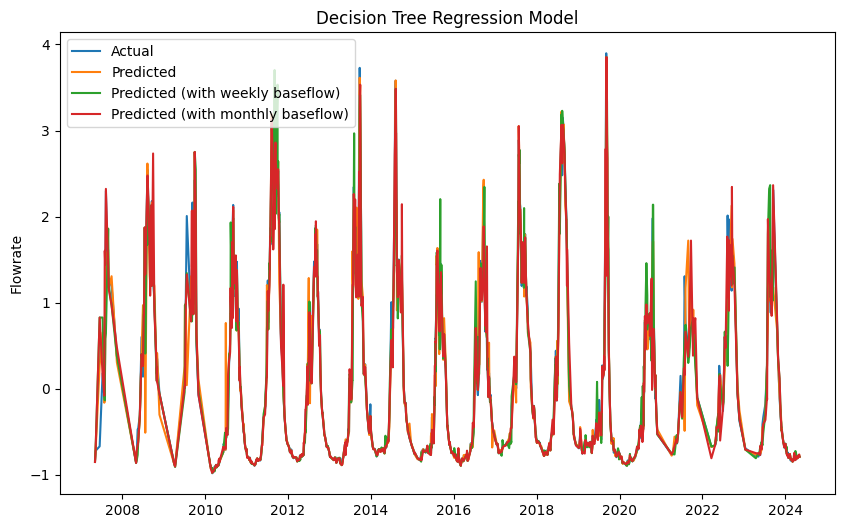

In [ ]:
## plot results ##

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index,dt_pred, label='Predicted')
plt.plot(y_test.index,dt_pred_week, label='Predicted (with weekly baseflow)')
plt.plot(y_test.index,dt_pred_month, label='Predicted (with monthly baseflow)')
plt.title('Decision Tree Regression Model')
plt.ylabel('Flowrate')
plt.legend()
plt.show()

In [ ]:
## Random Forest Regressor ##

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Evaluate model
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest Regressor Model")
print("Mean Squared Error:", rf_mse)
print("R-squared:", rf_r2)

# Get feature importances
rf_feature_importances = rf_model.feature_importances_

rf_importances_df = pd.DataFrame({'Feature': features, 'Importance': rf_feature_importances})
rf_importances_df = rf_importances_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
rf_importances_df

Random Forest Regressor Model
Mean Squared Error: 0.04063801925277185
R-squared: 0.9623530320199524

Feature Importances:


,Feature,Importance
5,day_of_year,0.447276
6,week_of_year,0.353649
1,year,0.134481
2,month,0.022259
3,day,0.018773
0,rainfall,0.014644
7,day_of_week_sin,0.003515
4,day_of_week,0.003056
8,day_of_week_cos,0.002349


In [ ]:
## Random Forest Regressor (with weekly baseflow) ##

rf_model_week = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_week.fit(X_train_week, y_train_week)
rf_pred_week = rf_model_week.predict(X_test_week)

# Evaluate model
rf_mse_week = mean_squared_error(y_test_week, rf_pred_week)
rf_r2_week = r2_score(y_test_week, rf_pred_week)

print("Random Forest Regressor Model (with weekly baseflow)")
print("Mean Squared Error:", rf_mse_week)
print("R-squared:", rf_r2_week)

rf_week_feature_importances = rf_model_week.feature_importances_
rf_week_features = X_week.columns

rf_week_importances_df = pd.DataFrame({'Feature': rf_week_features, 'Importance': rf_week_feature_importances})
rf_week_importances_df = rf_week_importances_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances (week base):")
rf_week_importances_df

Random Forest Regressor Model (with weekly baseflow)
Mean Squared Error: 0.036758599403373504
R-squared: 0.9659469176850737

Feature Importances (week base):


,Feature,Importance
9,min_flow_week,0.951694
5,day_of_year,0.012984
1,year,0.009635
0,rainfall,0.007114
3,day,0.007006
6,week_of_year,0.004459
7,day_of_week_sin,0.002083
4,day_of_week,0.001851
2,month,0.001786
8,day_of_week_cos,0.001390


In [ ]:
## Random Forest Regressor (with monthly baseflow) ##
rf_model_month = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_month.fit(X_train_month, y_train_month)
rf_pred_month = rf_model_month.predict(X_test_month)

# Evaluate model
rf_mse_month = mean_squared_error(y_test_month, rf_pred_month)
rf_r2_month = r2_score(y_test_month, rf_pred_month)

print("\nRandom Forest Regressor Model (with monthly baseflow)")
print("Mean Squared Error:", rf_mse_month)
print("R-squared:", rf_r2_month)

rf_month_feature_importances = rf_model_month.feature_importances_
rf_month_features = X_month.columns

rf_month_importances_df = pd.DataFrame({'Feature': rf_month_features, 'Importance': rf_month_feature_importances})
rf_month_importances_df = rf_month_importances_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances (month base):")
rf_month_importances_df


Random Forest Regressor Model (with monthly baseflow)
Mean Squared Error: 0.03444792914727729
R-squared: 0.9680875173191902

Feature Importances (month base):


,Feature,Importance
9,min_flow_month,0.669745
5,day_of_year,0.168753
6,week_of_year,0.071139
1,year,0.041611
2,month,0.018689
3,day,0.015329
0,rainfall,0.008632
7,day_of_week_sin,0.002333
4,day_of_week,0.002060
8,day_of_week_cos,0.001709


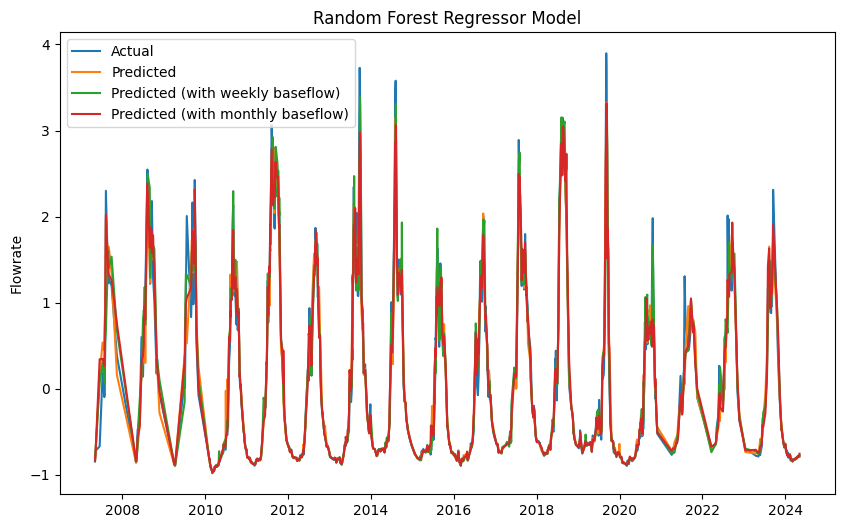

In [ ]:
## plot results ##
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index,rf_pred, label='Predicted')
plt.plot(y_test.index,rf_pred_week, label='Predicted (with weekly baseflow)')
plt.plot(y_test.index,rf_pred_month, label='Predicted (with monthly baseflow)')
plt.title('Random Forest Regressor Model')
plt.ylabel('Flowrate')
plt.legend()
plt.show()

In [ ]:
## XGBoost ##
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [ ]:
# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost Regressor Model")
print("Mean Squared Error:", xgb_mse)
print("R-squared:", xgb_r2)

# Feature importances
xgb_feature_importances = xgb_model.feature_importances_

xgb_importances_df = pd.DataFrame({'Feature': features, 'Importance': xgb_feature_importances})
xgb_importances_df = xgb_importances_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
xgb_importances_df

XGBoost Regressor Model
Mean Squared Error: 0.046615430525213004
R-squared: 0.9568155719046487

Feature Importances:


,Feature,Importance
6,week_of_year,0.658942
5,day_of_year,0.189023
2,month,0.072948
1,year,0.053248
0,rainfall,0.008785
3,day,0.007312
7,day_of_week_sin,0.003693
8,day_of_week_cos,0.003275
4,day_of_week,0.002774


In [ ]:
## XGBoost (with weekly baseflow) ##
xgb_model_week = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model_week.fit(X_train_week, y_train_week)
xgb_pred_week = xgb_model_week.predict(X_test_week)

# Evaluate the XGBoost Regressor
xgb_mse_week = mean_squared_error(y_test_week, xgb_pred_week)
xgb_r2_week = r2_score(y_test_week, xgb_pred_week)

print("XGBoost Regressor Model (with weekly baseflow)")
print("Mean Squared Error:", xgb_mse_week)
print("R-squared:", xgb_r2_week)

xgb_week_feature_importances = xgb_model_week.feature_importances_
xgb_week_features = X_week.columns

xgb_week_importances_df = pd.DataFrame({'Feature': xgb_week_features, 'Importance': xgb_week_feature_importances})
xgb_week_importances_df = xgb_week_importances_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances (week base):")
xgb_week_importances_df

XGBoost Regressor Model (with weekly baseflow)
Mean Squared Error: 0.036842561690289016
R-squared: 0.9658691352147378

Feature Importances (week base):


,Feature,Importance
9,min_flow_week,0.904190
5,day_of_year,0.018686
2,month,0.016725
6,week_of_year,0.016165
1,year,0.013851
3,day,0.010955
0,rainfall,0.007580
4,day_of_week,0.003987
8,day_of_week_cos,0.003976
7,day_of_week_sin,0.003885


In [ ]:
## XGBoost (with monthly baseflow) ##
xgb_model_month = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model_month.fit(X_train_month, y_train_month)
xgb_pred_month = xgb_model_month.predict(X_test_month)

# Evaluate the XGBoost Regressor
xgb_mse_month = mean_squared_error(y_test_month, xgb_pred_month)
xgb_r2_month = r2_score(y_test_month, xgb_pred_month)

print("\nXGBoost Regressor Model (with monthly baseflow)")
print("Mean Squared Error:", xgb_mse_month)
print("R-squared:", xgb_r2_month)

xgb_month_feature_importances = xgb_model_month.feature_importances_
xgb_month_features = X_month.columns

xgb_month_importances_df = pd.DataFrame({'Feature': xgb_month_features, 'Importance': xgb_month_feature_importances})
xgb_month_importances_df = xgb_month_importances_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances (month base):")
xgb_month_importances_df


XGBoost Regressor Model (with monthly baseflow)
Mean Squared Error: 0.03564759135550448
R-squared: 0.9669761529965573

Feature Importances (month base):


,Feature,Importance
9,min_flow_month,0.412622
6,week_of_year,0.278299
2,month,0.153048
5,day_of_year,0.091211
1,year,0.038149
3,day,0.009870
0,rainfall,0.008104
4,day_of_week,0.003222
8,day_of_week_cos,0.002784
7,day_of_week_sin,0.002690


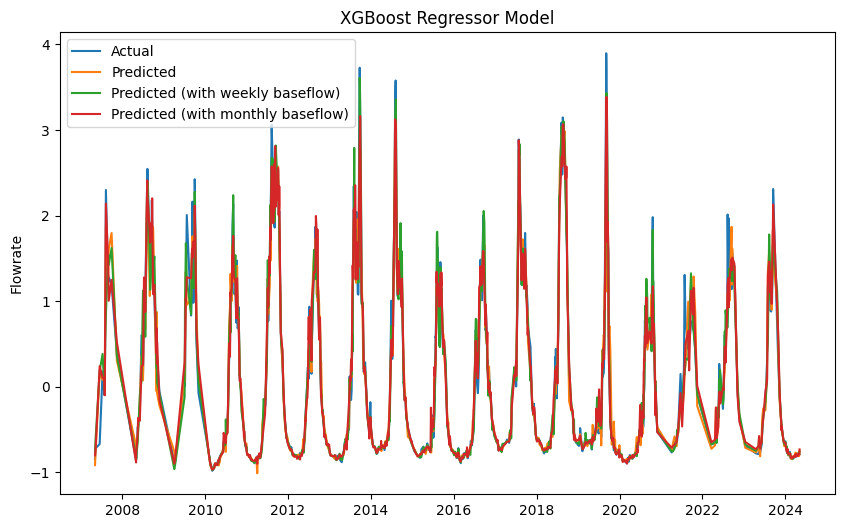

In [ ]:
## plot results ##

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index,xgb_pred, label='Predicted')
plt.plot(y_test.index,xgb_pred_week, label='Predicted (with weekly baseflow)')
plt.plot(y_test.index,xgb_pred_month, label='Predicted (with monthly baseflow)')
plt.title('XGBoost Regressor Model')
plt.ylabel('Flowrate')
plt.legend()
plt.show()

In [ ]:
## error comparison ##

error_df = pd.DataFrame({'Linear Regression': [lr_mse, lr_r2],
                         'Decision Tree': [dt_mse, dt_r2],
                         'Random Forest': [rf_mse, rf_r2],
                         'XGBoost': [xgb_mse, xgb_r2],
                         'Linear Regression (Week)': [lr_mse_week, lr_r2_week],
                         'Decision Tree (Week)': [dt_mse_week, dt_r2_week],
                         'Random Forest (Week)': [rf_mse_week, rf_r2_week],
                         'XGBoost (Week)': [xgb_mse_week, xgb_r2_week],
                         'Linear Regression (Month)': [lr_mse_month, lr_r2_month],
                         'Decision Tree (Month)': [dt_mse_month, dt_r2_month],
                         'Random Forest (Month)': [rf_mse_month, rf_r2_month],
                         'XGBoost (Month)': [xgb_mse_month, xgb_r2_month]},
                        index=['Mean Squared Error', 'R-squared'])

In [ ]:
# Sort the DataFrame by Mean Squared Error in descending order
error_df_sorted = error_df.T.sort_values(by='Mean Squared Error', ascending=True).T
error_df_sorted

,Random Forest (Month),XGBoost (Month),Random Forest (Week),XGBoost (Week),Random Forest,XGBoost,Decision Tree,Decision Tree (Week),Linear Regression (Week),Decision Tree (Month),Linear Regression (Month),Linear Regression
Mean Squared Error,0.034448,0.035648,0.036759,0.036843,0.040638,0.046615,0.050237,0.061865,0.062766,0.065116,0.356149,0.784276
R-squared,0.968088,0.966976,0.965947,0.965869,0.962353,0.956816,0.953461,0.942688,0.941854,0.939676,0.670065,0.273449


In [ ]:
## include in pptx slides ##

from pptx import Presentation
from pptx.util import Inches

file = 'C:\\Users\\lelia\\Documents\\0_X3A\\stage\\2024_05_20.pptx'
pres = Presentation(file)
slide = pres.slides[39]

# Define the size and position of the table
x, y, cx, cy = Inches(1), Inches(2), Inches(8.5), Inches(1.5)

error_df_sorted = error_df_sorted.round(4)
error_df_ppt = error_df_sorted.T

# Add the table to the slide
rows, cols = error_df_ppt.shape[0] + 1, error_df_ppt.shape[1]+1  # +1 for the header row and column
table = slide.shapes.add_table(rows, cols, x, y, cx, cy).table

# Set column headers
table.cell(0, 0).text = ''  # Empty top-left cell
for col_idx, col_name in enumerate(error_df_ppt.columns, start=1):
    table.cell(0, col_idx).text = col_name

# Set row headers
for row_idx, row_name in enumerate(error_df_ppt.index, start=1):
    table.cell(row_idx, 0).text = row_name

# Fill the table with DataFrame values
for row_idx, (index, row) in enumerate(error_df_ppt.iterrows(), start=1):
    for col_idx, value in enumerate(row, start=1):
        table.cell(row_idx, col_idx).text = f'{value:.5f}'

# Optional: Format the table
for col in range(cols):
    table.cell(0, col).text_frame.paragraphs[0].font.bold = True
for row in range(rows):
    table.cell(row, 0).text_frame.paragraphs[0].font.bold = True

pres.save(file)
print('sent to pptx')

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\lelia\\Documents\\0_X3A\\stage\\2024_05_20.pptx'

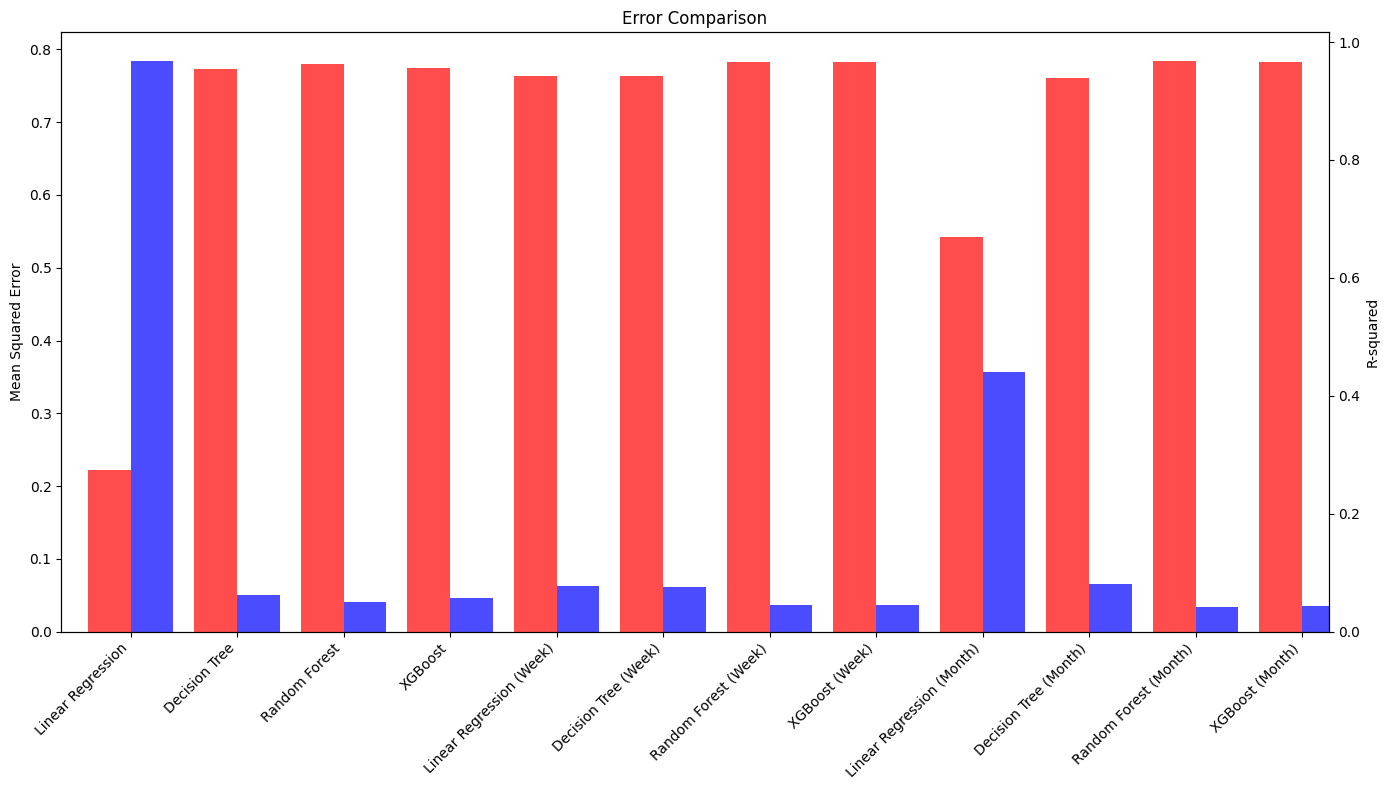

In [ ]:
## plot error comparison ##

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Mean Squared Error on the primary y-axis
error_df.loc['Mean Squared Error'].plot(kind='bar', ax=ax1, color='b', alpha=0.7, position=0, width=0.4)
ax1.set_ylabel('Mean Squared Error')

# Create a secondary y-axis for R-squared
ax2 = ax1.twinx()
error_df.loc['R-squared'].plot(kind='bar', ax=ax2, color='r', alpha=0.7, position=1, width=0.4)
ax2.set_ylabel('R-squared')


plt.title('Error Comparison')
ax1.set_xticklabels(error_df.columns, rotation=45, ha='right')
fig.tight_layout()
plt.show()

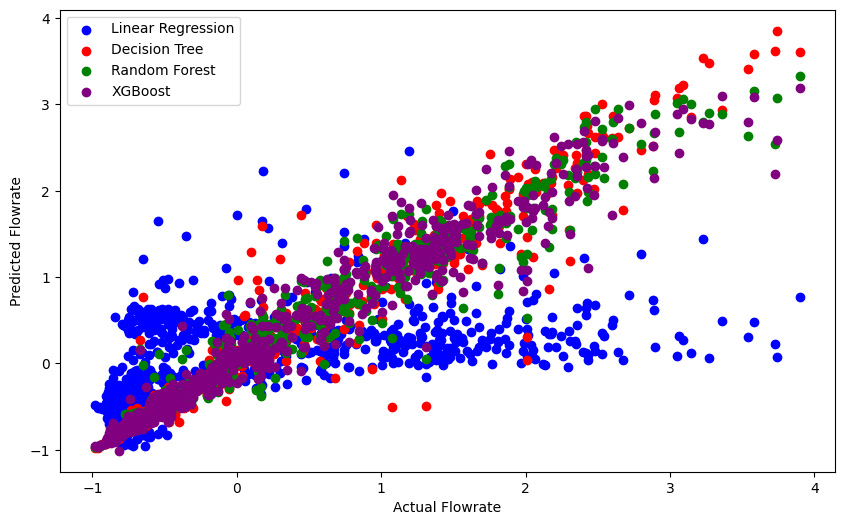

In [ ]:
## plot results ##

plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_pred, color='blue', label='Linear Regression')
plt.scatter(y_test, dt_pred, color='red', label='Decision Tree')
plt.scatter(y_test, rf_pred, color='green', label='Random Forest')
plt.scatter(y_test, xgb_pred, color='purple', label='XGBoost')
plt.xlabel('Actual Flowrate')
plt.ylabel('Predicted Flowrate')
plt.legend()
plt.show()


In [ ]:
# Filter columns that contain 'Linear Regression'
linear_regression_df = error_df.filter(like='XGBoost', axis=1)

linear_regression_df

,XGBoost,XGBoost (Week),XGBoost (Month)
Mean Squared Error,0.046615,0.036843,0.035648
R-squared,0.956816,0.965869,0.966976
